In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from IPython.display import display

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("../data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [3]:
# Анализируем количество наблюдений и признаков
# Признаки включают интересующую фичу Class

number_rows, number_columns = data.shape
print(f"Number of rows: {number_rows}")
print(f"Number of columns: {number_columns}")

Number of rows: 17996
Number of columns: 17


In [4]:
# Посмотрим предварительно типы переменных, которые присутствуют в нашем анализе
# Границу для отбора хноминативны переменных делаем в 11 категорий
# Такую границу поставила, исходя из key 

types_of_data = {'categorical': [], 'numerical': [], 'string': [], 'object': []}
for column in data.columns:
    if data[column].nunique() <= 11:
        data[column] = data[column].astype('category')
        types_of_data['categorical'].append(column)
    elif data[column].dtype == float or data[column].dtype == int:
        types_of_data['numerical'].append(column)
    elif data[column].dtype == object:
        if data[column].str.isnumeric().all():
            data[column] = data[column].astype('float') 
            types_of_data['numerical'].append(column)
        else:
            for element in data[column]:
                if type(element) is not str and element is not np.nan: 
                    types_of_data['object'].append(column)
                    break
            else:
                types_of_data['string'].append(column)
print('The DataFrame contains the following number of variables:')
common_inf = pd.DataFrame({'Categorical': [len(types_of_data['categorical'])], 
                               'Numerical': [len(types_of_data['numerical'])],
                               'String': [len(types_of_data['string'])],
                               'Object': [len(types_of_data['object'])]})
display(common_inf)
print('')
print(f"Categorical: {types_of_data['categorical']}")
print(f"Numerical: {types_of_data['numerical']}")
print(f"String: {types_of_data['string']}")
print(f"Object: {types_of_data['object']}")


The DataFrame contains the following number of variables:


,Categorical,Numerical,String,Object
0,4,11,2,0



Categorical: ['key', 'mode', 'time_signature', 'Class']
Numerical: ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms']
String: ['Artist Name', 'Track Name']
Object: []


#### Анализируем признаки

1. Категориальные
- key: тональность
- mode: лад
- time_signature: размер
- Class: жанр. Интересующая нас переменная

2. Количественные
- Popularity: популярность
- danceability: можно ли танцевать под песню
- energy: энергетика
- loudness: громкость
- speechiness: насыщенность словами
- acousticness: поддержка акустики
- instrumentalness: количество вокала в песне
- liveness: записана с живой аудиторией
- valence: уровень позитивности мызыки (?)
- tempo: темп
- duration_in min/ms: продолжительность

3. Строковые
- Название артиста
- Название трека


#### Анализируем пропущенные значения 

In [5]:
print(f"Overall the DataFrame has {data.isna().sum().sum()} NA")
count_na_string = 0
for _ in range(data.shape[0]):
    if data.iloc[_].isna().sum() > 0:
        count_na_string += 1
print(f"Missing values are in {count_na_string} strings")
columns_with_na = []
for _ in range(data.shape[1]):
    if data.isna().sum().iloc[_] > 0:
        columns_with_na += [data.columns[_]]
print(f"Missing values are in columnes: {columns_with_na}")

Overall the DataFrame has 6819 NA
Missing values are in 6183 strings
Missing values are in columnes: ['Popularity', 'key', 'instrumentalness']


In [6]:
data.isna().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

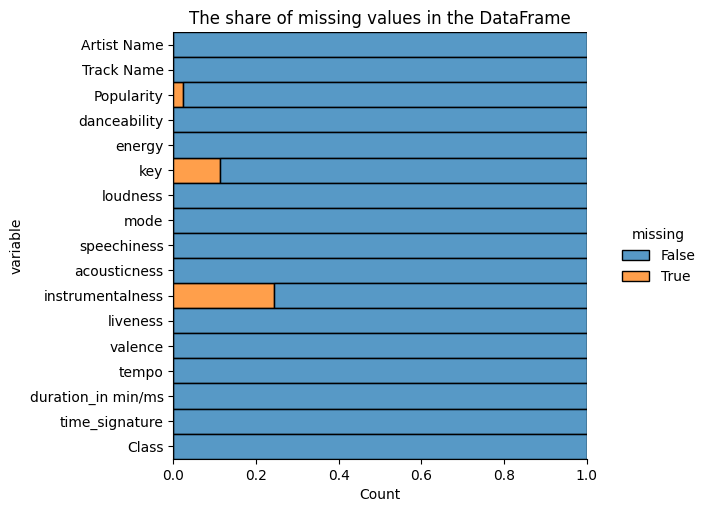

In [7]:
sns.displot(data=data.isna().melt(value_name="missing"), y="variable", hue="missing", multiple="fill", aspect=1.25)
plt.title('The share of missing values in the DataFrame')
plt.show()

**Анализ полученных NA**

У нас достаточно много NA значений, поэтому при удалении мы потеряем большое количество данных.

Скорее всего стоит их заменить. В случае количественных переменных заменяем NA на медианное значение. В категориальной переменной выполняю замену значений NA на моду. 

In [8]:
# Imputation

mode = data['key'].mode()
data['key'] = data['key'].fillna(mode[0])
data['Popularity'] = data['Popularity'].fillna(data['Popularity'].median())
data['instrumentalness'] = data['instrumentalness'].fillna(data['instrumentalness'].median())

#### Анализ дубликатов

In [9]:
# Тут проблем нет

print(f"The DataFrame contains {data.duplicated().sum()} duplicated rows")

The DataFrame contains 0 duplicated rows


#### Категориальные данные

In [10]:
for name in ['key', 'mode', 'time_signature', 'Class']:
    print(f"{name} has {data[name].cat.categories.size} categories:")
    categoric_count = pd.DataFrame({'': [0, 0]}, index=['Count', 'Share'])
    for category in data[name].cat.categories:
        count_of_category = data[name][data[name] == category].count()
        freq_of_category = round(count_of_category / data[name].count(), 3)
        categoric_count[category] = [count_of_category, freq_of_category]
    categoric_count = categoric_count.drop(columns='')
    display(categoric_count)

key has 11 categories:


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
Count,1680.000,1994.000,509.000,1549.000,1397.000,1190.000,4111.000,1119.000,1961.000,1010.000,1476.000
Share,0.093,0.111,0.028,0.086,0.078,0.066,0.228,0.062,0.109,0.056,0.082


mode has 2 categories:


,0,1
Count,6537.000,11459.000
Share,0.363,0.637


time_signature has 4 categories:


,1,3,4,5
Count,114.000,1228.000,16451.000,203.000
Share,0.006,0.068,0.914,0.011


Class has 11 categories:


,0,1,2,3,4,5,6,7,8,9,10
Count,625.000,1373.000,1272.000,402.000,387.000,1447.00,2587.000,576.000,1854.000,2524.00,4949.000
Share,0.035,0.076,0.071,0.022,0.022,0.08,0.144,0.032,0.103,0.14,0.275


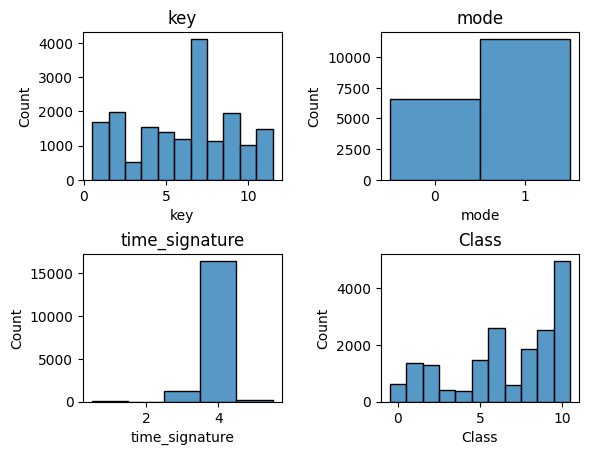

In [11]:
# Анализируем категориальные переменные на графиках

number=1
for i in ['key', 'mode', 'time_signature', 'Class']:
    plt.subplot(2, 2, number)
    sns.histplot(data[i])
    plt.title(i)
    number += 1
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Можем сделать вывод, что все категориальные переменные являются несбалансированными. Особенно это отображено на показателях размера. Размер 4/4 превалирует среди всех остальных.

Также стоит отметить дисбаланс в интересующей нас переменной Class. Есть явный сдвиг в сторону 10 жанра

#### Анализируем количественные переменные

In [12]:
data[['Popularity', 
      'danceability', 
      'energy', 
      'loudness', 
      'speechiness', 
      'acousticness', 
      'instrumentalness', 
      'liveness', 
      'valence', 
      'tempo', 
      'duration_in min/ms']].describe()

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms
count,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,1.799600e+04
mean,44.499944,0.543433,0.662777,-7.910660,0.079707,0.247082,0.135326,0.196170,0.486208,122.623294,2.007445e+05
std,17.218613,0.166268,0.235373,4.049151,0.083576,0.310632,0.274791,0.159212,0.240195,29.571527,1.119891e+05
min,1.000000,0.059600,0.000020,-39.952000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01
25%,33.000000,0.432000,0.509000,-9.538000,0.034800,0.004300,0.000294,0.097500,0.297000,99.620750,1.663370e+05
50%,44.000000,0.545000,0.700000,-7.016000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05
75%,56.000000,0.659000,0.860000,-5.189000,0.083000,0.434000,0.056600,0.258000,0.672000,141.969250,2.524900e+05
max,100.000000,0.989000,1.000000,1.355000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06


Уже тут можно обратить внимание на разницу дисперсий всех данных. Перед анализом их необходимо будет стандартизовать.

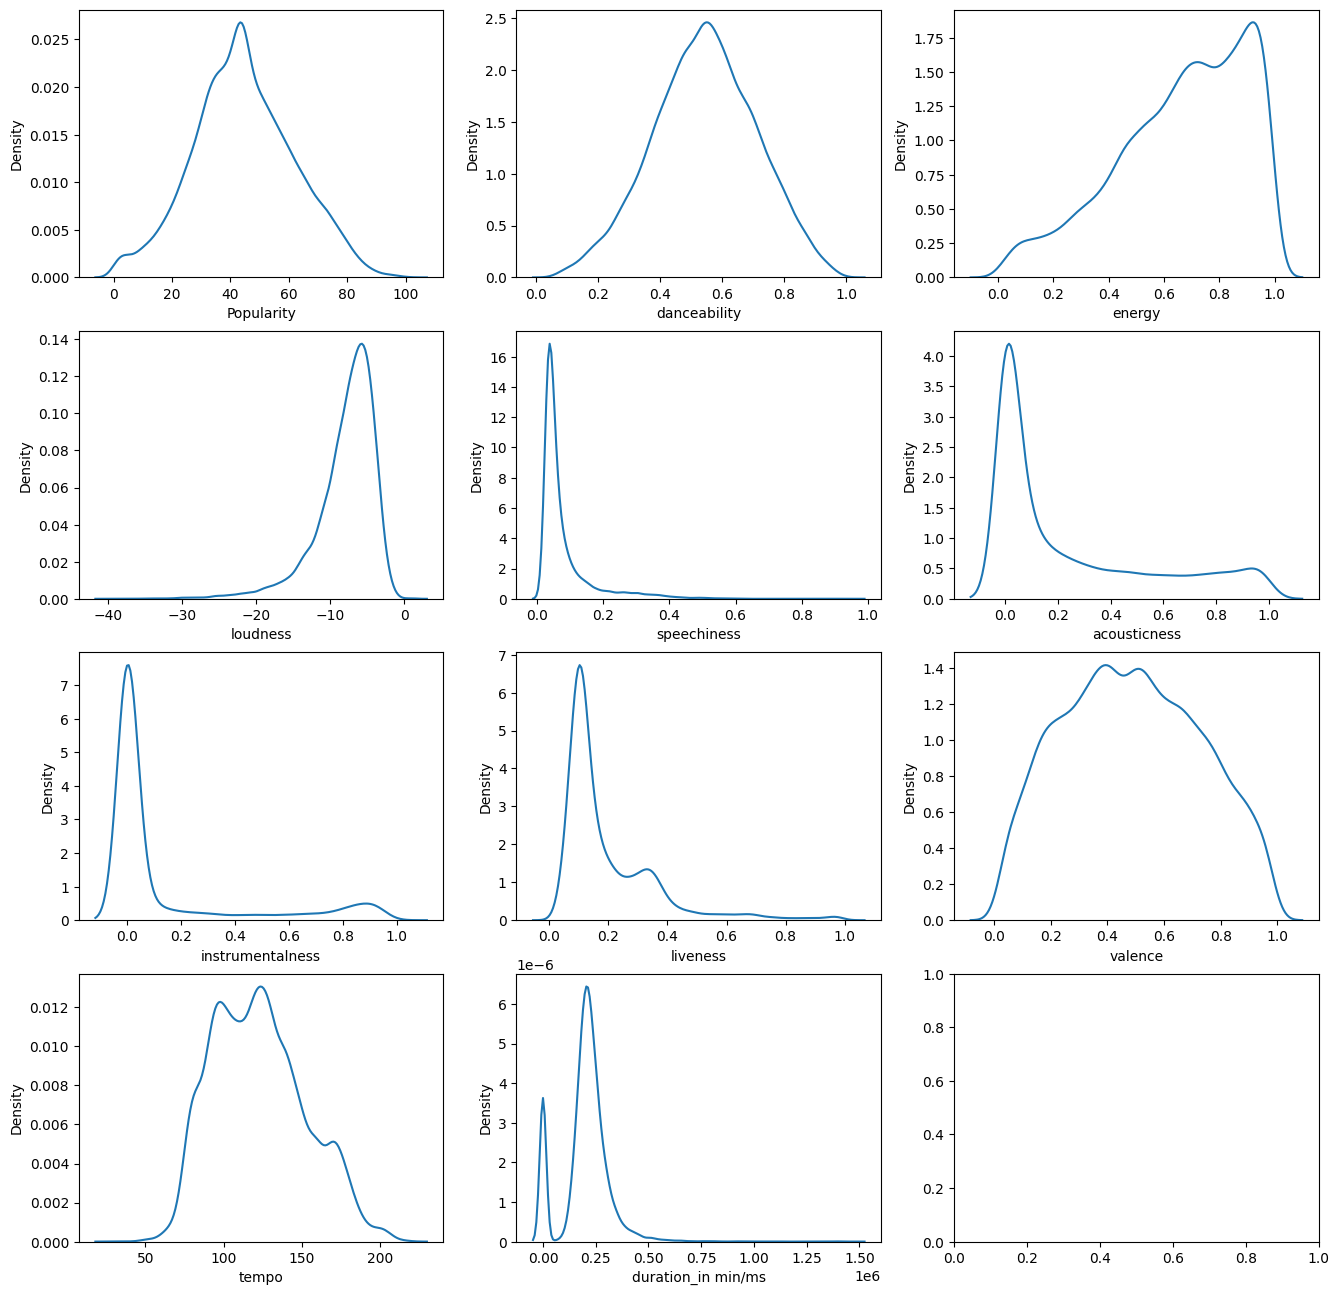

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
num_cols = ['Popularity', 
      'danceability', 
      'energy', 
      'loudness', 
      'speechiness', 
      'acousticness', 
      'instrumentalness', 
      'liveness', 
      'valence', 
      'tempo', 
      'duration_in min/ms']
number = 0
for nrow in range(4):
    for ncol in range(3):
        if number == 11:
            break
        sns.kdeplot(data[num_cols[number]], ax=axes[nrow][ncol])
        number += 1

Что можно отметить на этих графиках:
- Все показатели кроме popularity и danceabiluty имеют ненормальное распределение. Переменная tempo тоже имеет что-то похожее на колокол
- Продолжительность песни может принимать очень странные значения. Выглядит так, что часть измерений выполнена в минутах, а часть в миллисек. Переведу минуты в миллисекунды для дальнейшего анализа

In [14]:
# Перевожу мин в миллисек
# Все показатели меньше 1000 относятся к минутам

data['duration_ms'] = data['duration_in min/ms']
data['duration_ms'][data['duration_ms'] < 1000] = data['duration_ms'][data['duration_ms'] < 1000] * 60000

/var/folders/yn/8b9cs2_s6td7fmf54qzzqlj80000gn/T/ipykernel_6608/2956684022.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['duration_ms'][data['duration_ms'] < 1000] = data['duration_ms'][data['duration_ms'] < 1000] * 60000
/var/fol

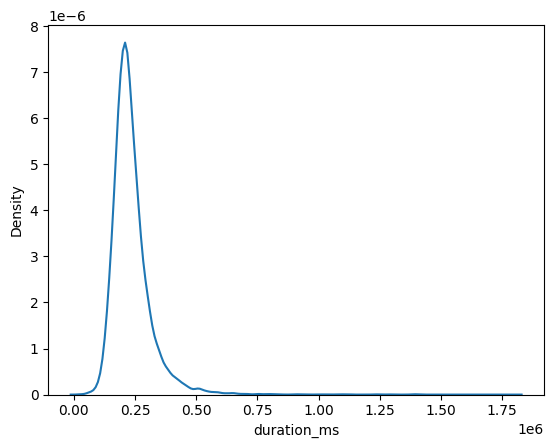

In [15]:
# Перевела все значения в миллисек

sns.kdeplot(data['duration_ms']);

In [16]:
# Удаляю исходную колонку

data = data.drop(columns=['duration_in min/ms'])

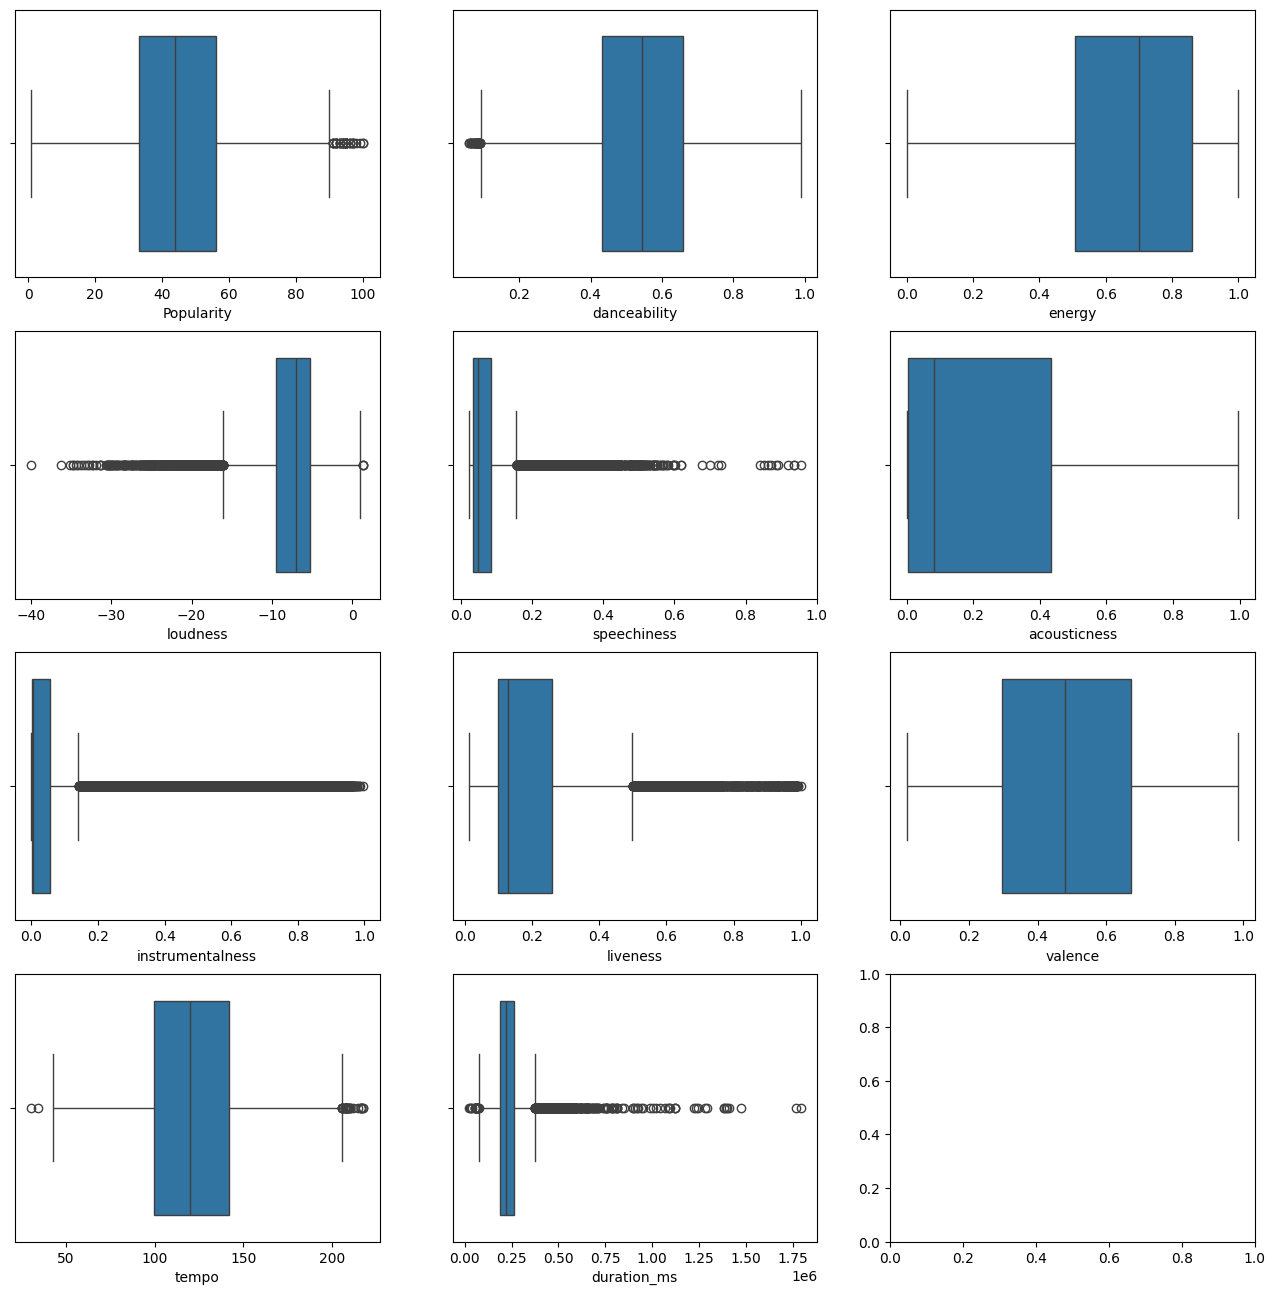

In [17]:
# Строю боксплоты для удобства отображения данных

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
num_cols = ['Popularity', 
      'danceability', 
      'energy', 
      'loudness', 
      'speechiness', 
      'acousticness', 
      'instrumentalness', 
      'liveness', 
      'valence', 
      'tempo', 
      'duration_ms']
number = 0
for nrow in range(4):
    for ncol in range(3):
        if number == 11:
            break
        sns.boxplot(x=data[num_cols[number]], ax=axes[nrow][ncol])
        number += 1

In [18]:
# Анализирую максимальные значения длительности аудиозаписей

data.nlargest(10, 'duration_ms')['duration_ms'] / 60000

14934    29.886000
1219     29.450000
14837    24.619783
2174     23.540850
14265    23.291550
4656     23.211117
10054    23.098450
13222    23.098450
6121     21.592667
2028     21.408450
Name: duration_ms, dtype: float64

**Анализ выбросов**

При анализе боксплотов выявляется большое количество выбросов. Я бы сказала, что это скорее всего особенности распределений, чем действительно уникальные значения. Больше всего меня смутили показатели длительности песен (по полчаса). Но таких показателей продолжительности достаточно много, поэтому учтем их при последующем анализе.

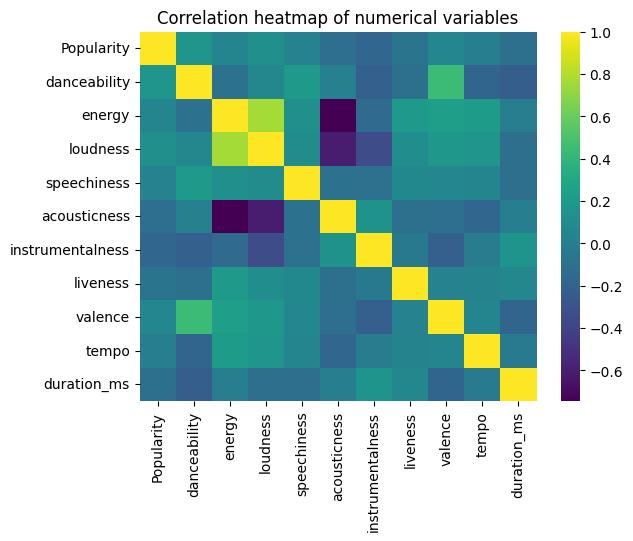

In [19]:
# Анализируем корреляцию между количественными переменными

sns.heatmap(data[num_cols].corr(), cmap=sns.color_palette("viridis", as_cmap=True))
plt.title('Correlation heatmap of numerical variables')
plt.show()

In [20]:
data[['loudness', 'energy', 'acousticness']].corr()

,loudness,energy,acousticness
loudness,1.000000,0.767869,-0.612824
energy,0.767869,1.000000,-0.745963
acousticness,-0.612824,-0.745963,1.000000


In [21]:
data[['danceability', 'valence']].corr()

,danceability,valence
danceability,1.000000,0.444548
valence,0.444548,1.000000


Наблюдаем явную корреляцию между переменными loudness, energy и acoustness. Ну тут и очевидно, чем громче музыка, тем она энергичнее. С другой стороны акустика обычно не ассоциируется с энергичной музыкой.

В меньшей степени выражена корреляция между танцевальностью и позитивностью, что тоже логично.

Для последующего анализа оставлю обе переменные. Оценю их значимость при построении модели.

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [22]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [23]:
# Определяем X и y
# Строковые переменные выбрасываю из анализа, так как они представляют уникальные значения

X = data.drop(columns=['Class', 'Artist Name', 'Track Name'])
y = data['Class']

In [24]:
# Разделяем выборку на тестовую и тренировочную

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [25]:
# Создаем Pipeline для обработки данных и создания классификатора

# Определяем колонки
num_cols = ['Popularity', 
      'danceability', 
      'energy', 
      'loudness', 
      'speechiness', 
      'acousticness', 
      'instrumentalness', 
      'liveness', 
      'valence', 
      'tempo', 
      'duration_ms']
cat_cols = ['key', 'mode', 'time_signature']

# Строим трансформер для процессинга данных
preprocessor = ColumnTransformer(transformers=[
    ('num_scaler', StandardScaler(), num_cols),
    ('cat_ohe', OneHotEncoder(drop='first'), cat_cols)
])

# Выполняем процессинг
processed_X_train = preprocessor.fit_transform(X_train)

In [26]:
# Создаем экземпляр классификатора 

clf = DecisionTreeClassifier()

In [27]:
# Выполняем подбор параметров
# Предварительно показала, что наилучшие показали показал метод энтропии
# Поэтому не вношу данный показатель в поиск
# min_samples_split оставляю на уровне 2 образцов 
# Это тоже оценила в процессе нескольких итераций

parameters = {'max_depth': range(1, 20), 
              'min_samples_leaf': range(1, 5), 
              'max_leaf_nodes': range(2, 20)}

grid_search_clf = GridSearchCV(clf, parameters, cv=5)

In [28]:
grid_search_clf.fit(processed_X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 20),
                         'max_leaf_nodes': range(2, 20),
                         'min_samples_leaf': range(1, 5)})

In [29]:
# В итоге получаем наилучшие гиперпараметры

grid_search_clf.best_params_

{'max_depth': 8, 'max_leaf_nodes': 19, 'min_samples_leaf': 1}

In [30]:
# Отбираем лучшую модель

best_clf = grid_search_clf.best_estimator_ 

In [31]:
# Процессируем данные X-test

processed_X_test = preprocessor.transform(X_test)

In [32]:
prediction_train = best_clf.predict(processed_X_train)
prediction_test = best_clf.predict(processed_X_test)

**Определяю метрики для двух выборок**

In [33]:
# Train

accuracy = accuracy_score(y_train, prediction_train)
precision = precision_score(y_train, prediction_train, average='macro', zero_division=0)
recall = recall_score(y_train, prediction_train, average='macro')
f1 = f1_score(y_train, prediction_train, average='macro', zero_division=0)

print(f'Accuracy is {accuracy}')
print(f'Precision is {precision}')
print(f'Recall is {recall}')
print(f'F1-score is {f1}')

Accuracy is 0.43128102541305474
Precision is 0.30317724891484055
Recall is 0.3217772952494892
F1-score is 0.3044409215342357


In [34]:
# Test

accuracy = accuracy_score(y_test, prediction_test)
precision = precision_score(y_test, prediction_test, average='macro', zero_division=0)
recall = recall_score(y_test, prediction_test, average='macro')
f1 = f1_score(y_test, prediction_test, average='macro', zero_division=0)

print(f'Accuracy is {accuracy}')
print(f'Precision is {precision}')
print(f'Recall is {recall}')
print(f'F1-score is {f1}')

Accuracy is 0.42565014447655036
Precision is 0.29701649445757405
Recall is 0.31404968736041905
F1-score is 0.2978614549324657


**Предварительный вывод**
- Использование деревьев решений дает нам очень не высокие показатели метрик при предсказании жанра

**Анализирую вклад каждой переменной в нашу модель**

In [37]:
best_clf.feature_importances_

array([0.04921395, 0.07857079, 0.14888136, 0.        , 0.22456473,
       0.26600363, 0.13384882, 0.        , 0.08341605, 0.        ,
       0.01550067, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [38]:
preprocessor.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(transformers=[('num_scaler', StandardScaler(),
                                 ['Popularity', 'danceability', 'energy',
                                  'loudness', 'speechiness', 'acousticness',
                                  'instrumentalness', 'liveness', 'valence',
                                  'tempo', 'duration_ms']),
                                ('cat_ohe', OneHotEncoder(drop='first'),
                                 ['key', 'mode', 'time_signature'])])>

В нашем анализе были использованы 11 количественных переменных и 14 категорий номинативных переменных. Из показателей "важности признаков" уже видно, что наибольший вклад в классификацию внесли количественные перменные. Для удобства построим с ними таблицу.

In [39]:
num_importance = best_clf.feature_importances_[:11]

value_num_feature = pd.DataFrame({'Feature': num_cols, 'Importance': num_importance})
display(value_num_feature)

,Feature,Importance
0,Popularity,0.049214
1,danceability,0.078571
2,energy,0.148881
3,loudness,0.000000
4,speechiness,0.224565
5,acousticness,0.266004
6,instrumentalness,0.133849
7,liveness,0.000000
8,valence,0.083416
9,tempo,0.000000


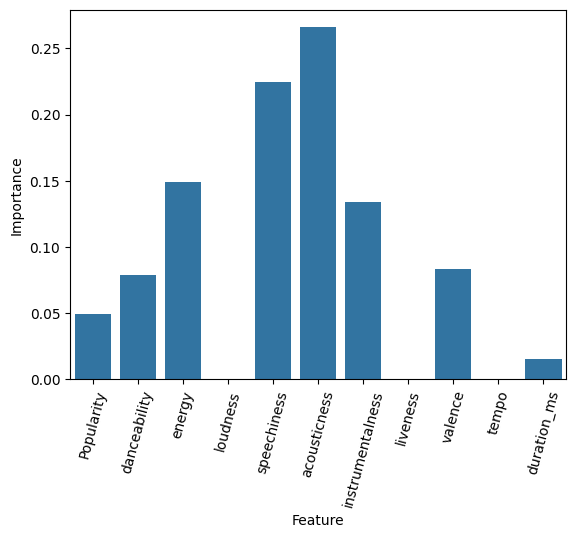

In [40]:
sns.barplot(value_num_feature, x=value_num_feature['Feature'], y=value_num_feature['Importance'])
plt.xticks(rotation=75);

**Выводы**
1. Категориальнае переменные key(тональность), mode (лад), time_signature (размер) не значимы для классификации жанров
2. Среди количественных переменных наибольшую значимость для классификации имеют acousticness (акустика), speechiness(насыщенность словами), energy(энергетика) и instrumentalness(вокал в песне)
3. Перед анализом стоило удалить признак loudness, так как он сильно коррелирует с energy. Из анализа видно, что данный показатель не несет дополнительной информации после разделения по признаку energy. Переделывать анализ без этой переменной нет смысла, так как мы получим аналогичные результаты.
4. Дерево решений имеет очень низкие показатели метрик при классификации жанров. В данном случае лучше использовать другую модель

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

In [42]:
# Создаем классификатор

knn_clf = KNeighborsClassifier()

In [45]:
# Подбираем параметры

parameters = {'n_neighbors': range(1, 30)}

grid_search_knn_clf = GridSearchCV(knn_clf, parameters, cv=5)

In [46]:
grid_search_knn_clf.fit(processed_X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30)})

In [47]:
# Определяем лучшие параметры

grid_search_knn_clf.best_params_

{'n_neighbors': 26}

In [48]:
# Выбираем лучший классификатор

best_knn_clf = grid_search_knn_clf.best_estimator_ 

In [49]:
# Делаем предсказания

prediction_knn_train = best_knn_clf.predict(processed_X_train)
prediction_knn_test = best_knn_clf.predict(processed_X_test)

In [52]:
# Анализируем метрики
# Train

accuracy = accuracy_score(y_train, prediction_knn_train)
precision = precision_score(y_train, prediction_knn_train, average='macro', zero_division=0)
recall = recall_score(y_train, prediction_knn_train, average='macro')
f1 = f1_score(y_train, prediction_knn_train, average='macro', zero_division=0)

print(f'Accuracy is {accuracy}')
print(f'Precision is {precision}')
print(f'Recall is {recall}')
print(f'F1-score is {f1}')

Accuracy is 0.4984070534192784
Precision is 0.5063226185710412
Recall is 0.43047603911555915
F1-score is 0.43514312886387646


In [53]:
# Test

accuracy = accuracy_score(y_test, prediction_knn_test)
precision = precision_score(y_test, prediction_knn_test, average='macro', zero_division=0)
recall = recall_score(y_test, prediction_knn_test, average='macro')
f1 = f1_score(y_test, prediction_knn_test, average='macro', zero_division=0)

print(f'Accuracy is {accuracy}')
print(f'Precision is {precision}')
print(f'Recall is {recall}')
print(f'F1-score is {f1}')

Accuracy is 0.45410091131362523
Precision is 0.44487419458832184
Recall is 0.39541878840226924
F1-score is 0.3985945159554359


**Вывод**

kNN классификатор в данном случае показывает лучше показатели метрик. Хотя тоже не очень высокие

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

Не люблю спойлерить и подробно рассказывать про сериалы, поэтому просто перечислю с некоторыми описаниями.

1. Сериал Дрянь
   
Коротюсенький британский сериал. Чёрный юмор и слёзы.

2. Сериал Undone

Только 1 сезон хорош. Он про шизофрению

3. Фильм Банши Инишерина

Фильм Мартина Макдоны. Ну тут больше ничего добавлять и не надо.